In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    auc, precision_recall_curve, average_precision_score
)

from sklearn.inspection import permutation_importance

In [2]:
print("STEP 1: DATA LOADING AND EXPLORATION")
df = pd.read_csv('leukemia_Positive.csv')
print(f"\n - Dataset Shape: {df.shape}")
print(f"   - Total Samples: {df.shape[0]:,}")
print(f"   - Total Features: {df.shape[1]}")

print("\nFirst 5 Rows:")
print(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found!")
else:
    print(missing[missing > 0])

print("\nDiagnosis Distribution:")
diagnosis_counts = df['Diagnosis'].value_counts()
print(diagnosis_counts)
print("\nPercentage Distribution:")
print(df['Diagnosis'].value_counts(normalize=True) * 100)


STEP 1: DATA LOADING AND EXPLORATION

 - Dataset Shape: (10000, 12)
   - Total Samples: 10,000
   - Total Features: 12

First 5 Rows:
    Sample_ID  Ct_JAK2_V617F  Ct_microRNA_155  Ct_HLA_Tcell  Ct_REF_GAPDH  \
0  GENX_00001          26.49            21.30         28.22         17.03   
1  GENX_00002          24.59            22.24         27.99         18.42   
2  GENX_00003          26.94            21.51         23.72         19.12   
3  GENX_00004          29.57            23.28         29.03         20.22   
4  GENX_00005          24.30            25.99         21.78         21.54   

      Hb   RBC   WBC  Platelet  Drug_Resistance_Index  ΔCt_JAK2  \
0  14.06  5.06  8.20    325.61                   0.32      9.46   
1  17.03  4.96  9.41    389.24                   0.90      6.17   
2  14.60  5.57  8.85    179.58                   0.04      7.82   
3  15.18  5.92  4.81    439.17                   0.32      9.35   
4  16.43  5.41  7.53    326.41                   0.88      2.76   



STEP 2: DATA VISUALIZATION


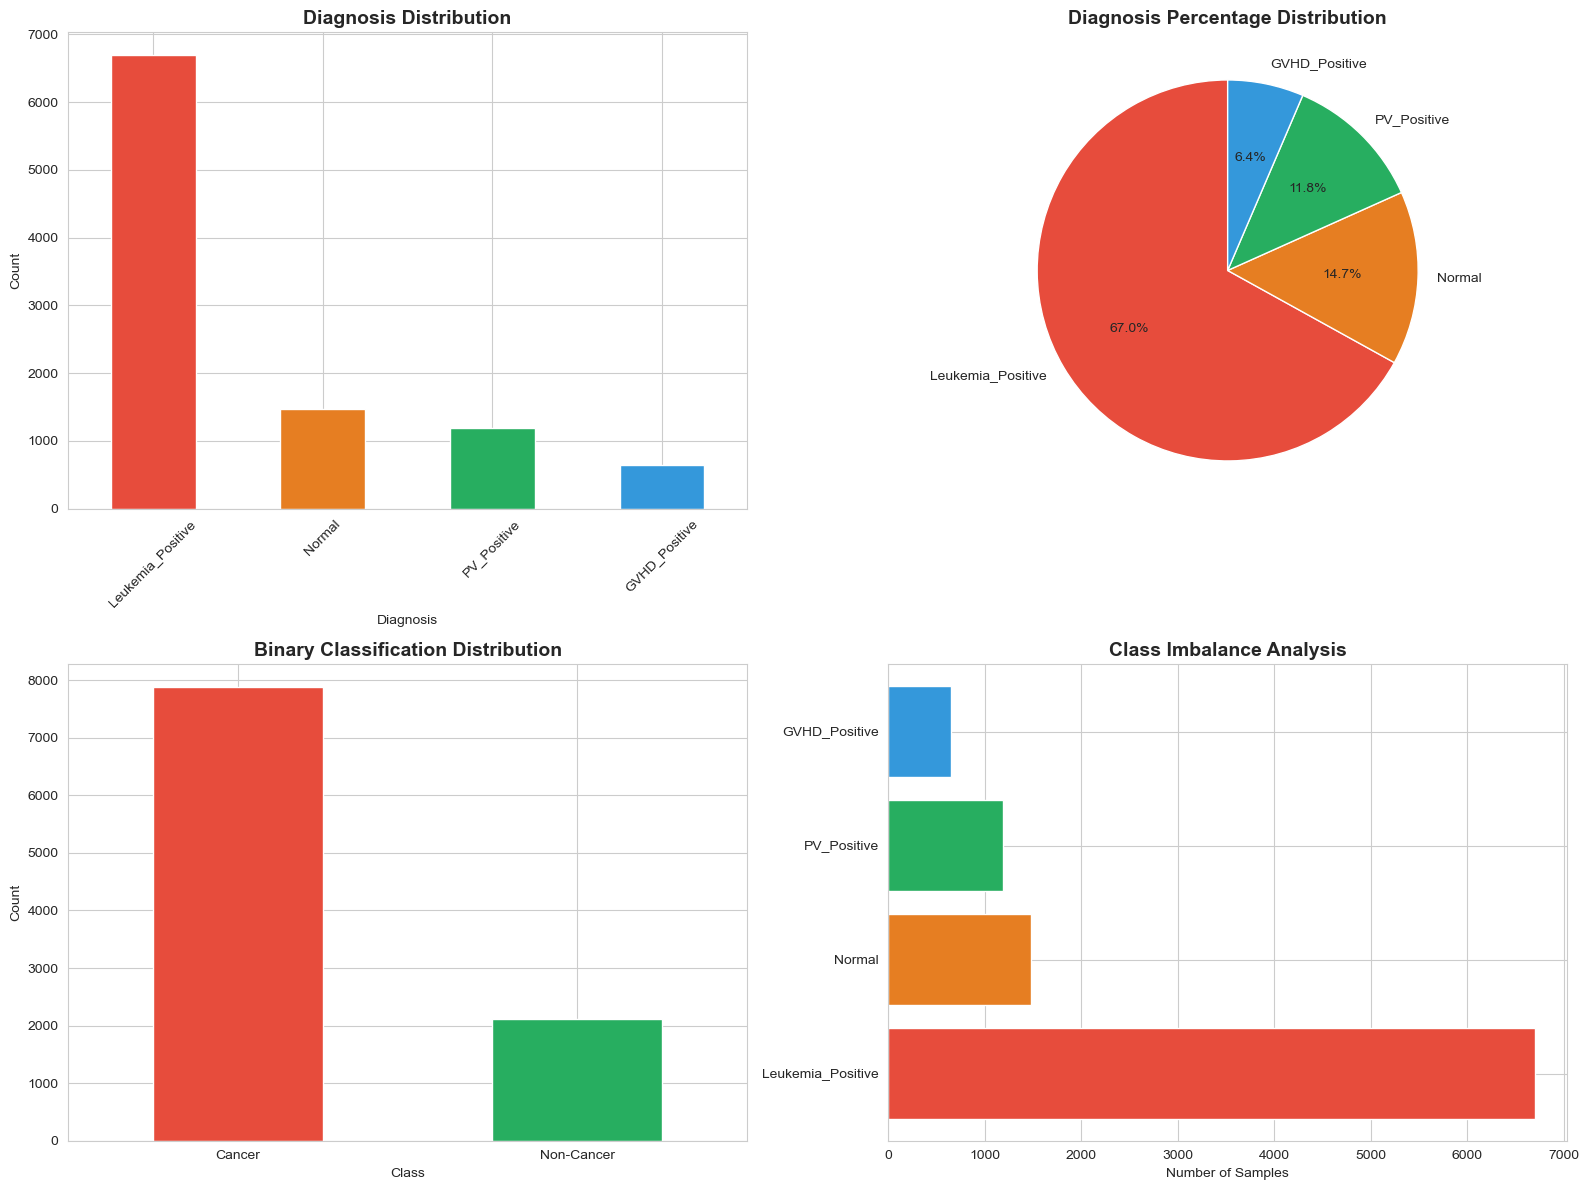

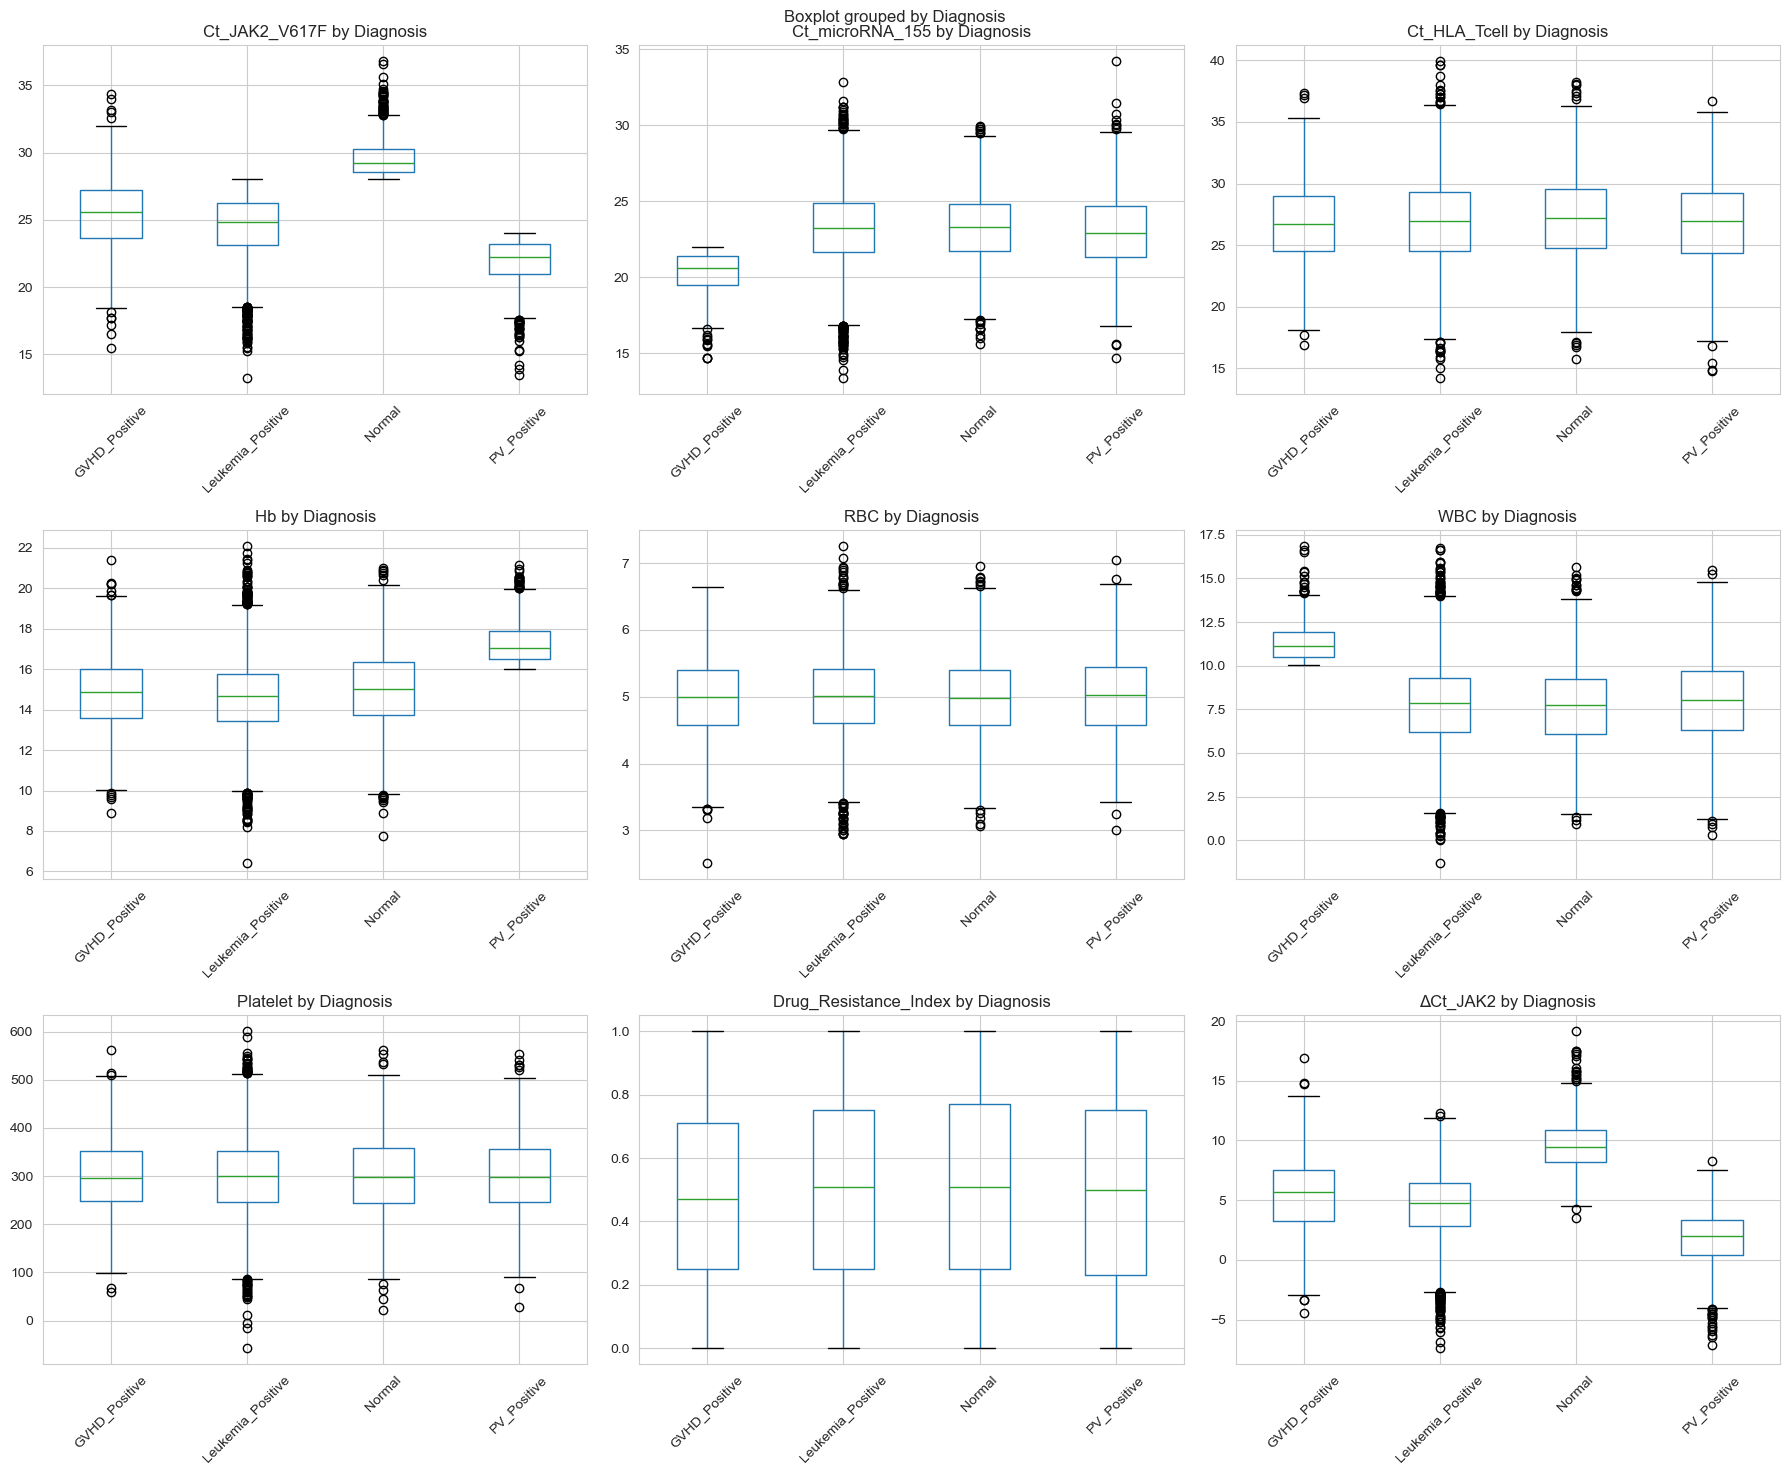

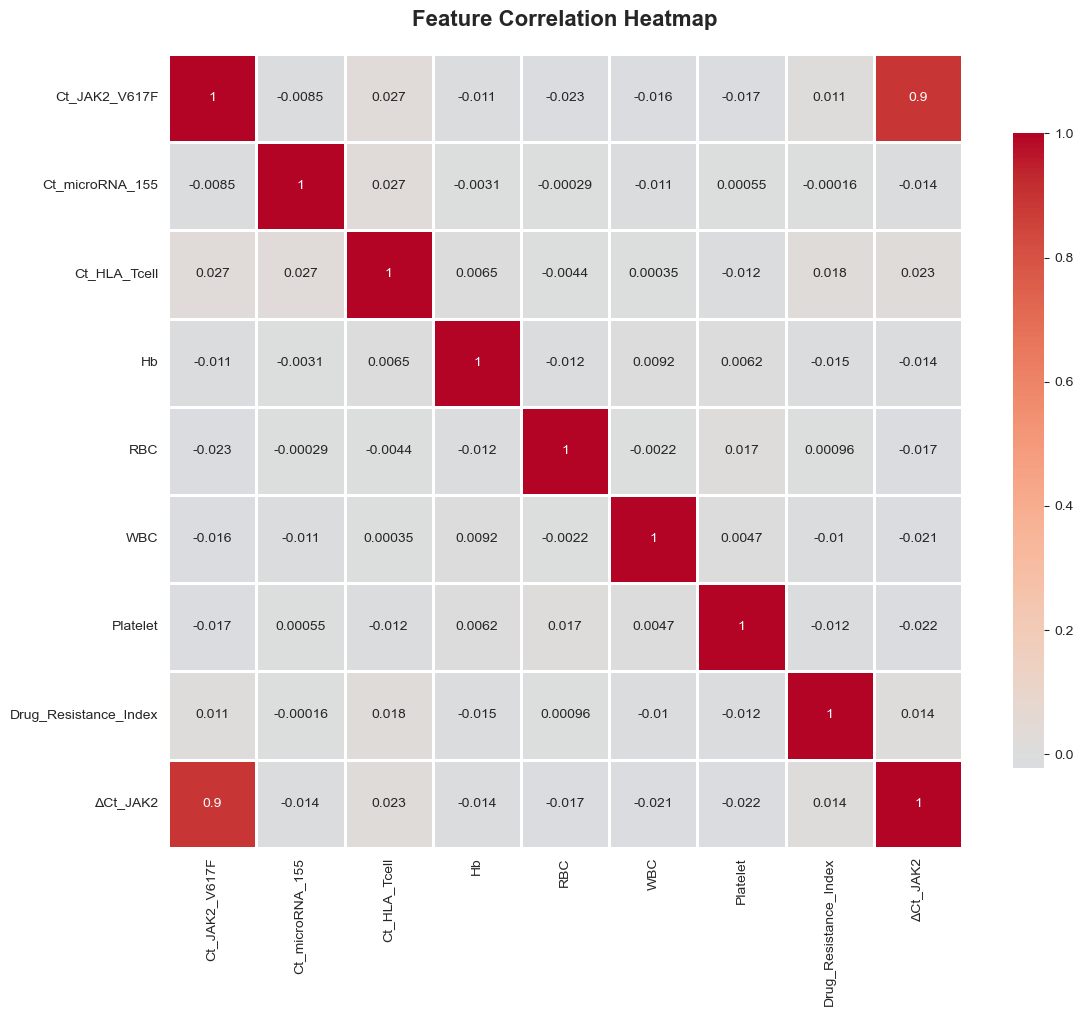

In [3]:
print("STEP 2: DATA VISUALIZATION")
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Diagnosis Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Bar plot
diagnosis_counts.plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#e67e22', '#27ae60', '#3498db'])
axes[0, 0].set_title('Diagnosis Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Diagnosis')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Pie chart
colors = ['#e74c3c', '#e67e22', '#27ae60', '#3498db']
axes[0, 1].pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 1].set_title('Diagnosis Percentage Distribution', fontsize=14, fontweight='bold')

# Binary classification distribution
df['Binary_Class'] = df['Diagnosis'].apply(
    lambda x: 'Cancer' if x in ['Leukemia_Positive', 'PV_Positive'] else 'Non-Cancer'
)
binary_counts = df['Binary_Class'].value_counts()
binary_counts.plot(kind='bar', ax=axes[1, 0], color=['#e74c3c', '#27ae60'])
axes[1, 0].set_title('Binary Classification Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=0)

# Class imbalance visualization
axes[1, 1].barh(diagnosis_counts.index, diagnosis_counts.values, color=colors)
axes[1, 1].set_title('Class Imbalance Analysis', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Samples')

plt.tight_layout()
plt.show()

numeric_features = ['Ct_JAK2_V617F', 'Ct_microRNA_155', 'Ct_HLA_Tcell', 'Hb', 
                    'RBC', 'WBC', 'Platelet', 'Drug_Resistance_Index', 'ΔCt_JAK2']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    df.boxplot(column=feature, by='Diagnosis', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Diagnosis')
    axes[idx].set_xlabel('')
    plt.sca(axes[idx])
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
print("STEP 3: DATA PREPROCESSING")

# Prepare features and target
X = df[numeric_features].copy()
y_multiclass = df['Diagnosis'].copy()
y_binary = df['Binary_Class'].copy()

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Multi-class Target Shape: {y_multiclass.shape}")
print(f"Binary Target Shape: {y_binary.shape}")

# Encode labels
le_multiclass = LabelEncoder()
le_binary = LabelEncoder()

y_multiclass_encoded = le_multiclass.fit_transform(y_multiclass)
y_binary_encoded = le_binary.fit_transform(y_binary)

print(f"\nMulti-class Label Encoding:")
for i, label in enumerate(le_multiclass.classes_):
    print(f"   {label} → {i}")

print(f"\nBinary Label Encoding:")
for i, label in enumerate(le_binary.classes_):
    print(f"   {label} → {i}")

# Train-Test Split
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass_encoded, test_size=0.2, random_state=42, stratify=y_multiclass_encoded
)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary_encoded, test_size=0.2, random_state=42, stratify=y_binary_encoded
)

print(f"\nTrain-Test Split (80-20):")
print(f"   Training Set: {X_train.shape[0]:,} samples")
print(f"   Test Set: {X_test.shape[0]:,} samples")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_bin_scaled = scaler.fit_transform(X_train_bin)
X_test_bin_scaled = scaler.transform(X_test_bin)

print("\n✓ Features scaled using StandardScaler")

# Handle Class Imbalance with SMOTE
print("\n⚖️  Handling Class Imbalance with SMOTE...")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_multi_balanced = smote.fit_resample(X_train_scaled, y_train_multi)
X_train_bin_balanced, y_train_bin_balanced = smote.fit_resample(X_train_bin_scaled, y_train_bin)

print(f"   Original Training Size: {X_train_scaled.shape[0]:,}")
print(f"   Balanced Training Size: {X_train_balanced.shape[0]:,}")
print("\n   Class Distribution After SMOTE:")
unique, counts = np.unique(y_train_multi_balanced, return_counts=True)
for u, c in zip(unique, counts):
    print(f"   {le_multiclass.classes_[u]}: {c:,}")

print("\n✓ Data preprocessing completed!")


STEP 3: DATA PREPROCESSING

Feature Matrix Shape: (10000, 9)
Multi-class Target Shape: (10000,)
Binary Target Shape: (10000,)

Multi-class Label Encoding:
   GVHD_Positive → 0
   Leukemia_Positive → 1
   Normal → 2
   PV_Positive → 3

Binary Label Encoding:
   Cancer → 0
   Non-Cancer → 1

Train-Test Split (80-20):
   Training Set: 8,000 samples
   Test Set: 2,000 samples

✓ Features scaled using StandardScaler

⚖️  Handling Class Imbalance with SMOTE...
   Original Training Size: 8,000
   Balanced Training Size: 21,428

   Class Distribution After SMOTE:
   GVHD_Positive: 5,357
   Leukemia_Positive: 5,357
   Normal: 5,357
   PV_Positive: 5,357

✓ Data preprocessing completed!


In [5]:
print("STEP 4: BINARY CLASSIFICATION (Cancer vs Non-Cancer)")

# Dictionary to store results
binary_results = {}

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a classification model"""
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    # ROC-AUC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    return results

# Logistic Regression
print("\n" + "-"*80)
print("LOGISTIC REGRESSION")
print("-"*80)

lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)

lr_results = evaluate_model(
    lr_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'Logistic Regression'
)
binary_results['Logistic Regression'] = lr_results

print(f"Accuracy:  {lr_results['Accuracy']:.4f}")
print(f"Precision: {lr_results['Precision']:.4f}")
print(f"Recall:    {lr_results['Recall']:.4f}")
print(f"F1-Score:  {lr_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {lr_results['ROC-AUC']:.4f}")
print(f"CV Score:  {lr_results['CV_Mean']:.4f} (+/- {lr_results['CV_Std']:.4f})")

# Random Forest
print("\n" + "-"*80)
print("RANDOM FOREST CLASSIFIER")
print("-"*80)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_results = evaluate_model(
    rf_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'Random Forest'
)
binary_results['Random Forest'] = rf_results

print(f"Accuracy:  {rf_results['Accuracy']:.4f}")
print(f"Precision: {rf_results['Precision']:.4f}")
print(f"Recall:    {rf_results['Recall']:.4f}")
print(f"F1-Score:  {rf_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {rf_results['ROC-AUC']:.4f}")
print(f"CV Score:  {rf_results['CV_Mean']:.4f} (+/- {rf_results['CV_Std']:.4f})")

# XGBoost
print("\n" + "-"*80)
print("XGBOOST CLASSIFIER")
print("-"*80)

# Calculate scale_pos_weight for imbalanced classes
scale_pos_weight = (y_train_bin_balanced == 0).sum() / (y_train_bin_balanced == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_results = evaluate_model(
    xgb_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'XGBoost'
)
binary_results['XGBoost'] = xgb_results

print(f"Accuracy:  {xgb_results['Accuracy']:.4f}")
print(f"Precision: {xgb_results['Precision']:.4f}")
print(f"Recall:    {xgb_results['Recall']:.4f}")
print(f"F1-Score:  {xgb_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {xgb_results['ROC-AUC']:.4f}")
print(f"CV Score:  {xgb_results['CV_Mean']:.4f} (+/- {xgb_results['CV_Std']:.4f})")

# Gradient Boosting
print("\n" + "-"*80)
print("GRADIENT BOOSTING CLASSIFIER")
print("-"*80)

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    random_state=42,
    subsample=0.8
)

gb_results = evaluate_model(
    gb_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'Gradient Boosting'
)
binary_results['Gradient Boosting'] = gb_results

print(f"Accuracy:  {gb_results['Accuracy']:.4f}")
print(f"Precision: {gb_results['Precision']:.4f}")
print(f"Recall:    {gb_results['Recall']:.4f}")
print(f"F1-Score:  {gb_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {gb_results['ROC-AUC']:.4f}")
print(f"CV Score:  {gb_results['CV_Mean']:.4f} (+/- {gb_results['CV_Std']:.4f})")

# Support Vector Machine
print("\n" + "-"*80)
print("SUPPORT VECTOR MACHINE (SVM)")
print("-"*80)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_results = evaluate_model(
    svm_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'SVM'
)
binary_results['SVM'] = svm_results

print(f"Accuracy:  {svm_results['Accuracy']:.4f}")
print(f"Precision: {svm_results['Precision']:.4f}")
print(f"Recall:    {svm_results['Recall']:.4f}")
print(f"F1-Score:  {svm_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {svm_results['ROC-AUC']:.4f}")
print(f"CV Score:  {svm_results['CV_Mean']:.4f} (+/- {svm_results['CV_Std']:.4f})")

# Neural Network (MLP)
print("\n" + "-"*80)
print("MULTI-LAYER PERCEPTRON (NEURAL NETWORK)")
print("-"*80)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_results = evaluate_model(
    mlp_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'Neural Network (MLP)'
)
binary_results['Neural Network'] = mlp_results

print(f"Accuracy:  {mlp_results['Accuracy']:.4f}")
print(f"Precision: {mlp_results['Precision']:.4f}")
print(f"Recall:    {mlp_results['Recall']:.4f}")
print(f"F1-Score:  {mlp_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {mlp_results['ROC-AUC']:.4f}")
print(f"CV Score:  {mlp_results['CV_Mean']:.4f} (+/- {mlp_results['CV_Std']:.4f})")

# K-Nearest Neighbors
print("\n" + "-"*80)
print("K-NEAREST NEIGHBORS (KNN)")
print("-"*80)

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='minkowski',
    n_jobs=-1
)

knn_results = evaluate_model(
    knn_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'KNN'
)
binary_results['KNN'] = knn_results

print(f"Accuracy:  {knn_results['Accuracy']:.4f}")
print(f"Precision: {knn_results['Precision']:.4f}")
print(f"Recall:    {knn_results['Recall']:.4f}")
print(f"F1-Score:  {knn_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {knn_results['ROC-AUC']:.4f}")
print(f"CV Score:  {knn_results['CV_Mean']:.4f} (+/- {knn_results['CV_Std']:.4f})")

# Decision Tree
print("\n" + "-"*80)
print("DECISION TREE CLASSIFIER")
print("-"*80)

dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

dt_results = evaluate_model(
    dt_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'Decision Tree'
)
binary_results['Decision Tree'] = dt_results

print(f"Accuracy:  {dt_results['Accuracy']:.4f}")
print(f"Precision: {dt_results['Precision']:.4f}")
print(f"Recall:    {dt_results['Recall']:.4f}")
print(f"F1-Score:  {dt_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {dt_results['ROC-AUC']:.4f}")
print(f"CV Score:  {dt_results['CV_Mean']:.4f} (+/- {dt_results['CV_Std']:.4f})")

# Naive Bayes
print("\n" + "-"*80)
print("GAUSSIAN NAIVE BAYES")
print("-"*80)

nb_model = GaussianNB()

nb_results = evaluate_model(
    nb_model, X_train_bin_balanced, X_test_bin_scaled, 
    y_train_bin_balanced, y_test_bin, 'Naive Bayes'
)
binary_results['Naive Bayes'] = nb_results

print(f"Accuracy:  {nb_results['Accuracy']:.4f}")
print(f"Precision: {nb_results['Precision']:.4f}")
print(f"Recall:    {nb_results['Recall']:.4f}")
print(f"F1-Score:  {nb_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {nb_results['ROC-AUC']:.4f}")
print(f"CV Score:  {nb_results['CV_Mean']:.4f} (+/- {nb_results['CV_Std']:.4f})")


STEP 4: BINARY CLASSIFICATION (Cancer vs Non-Cancer)

--------------------------------------------------------------------------------
LOGISTIC REGRESSION
--------------------------------------------------------------------------------
Accuracy:  0.8550
Precision: 0.6120
Recall:    0.8632
F1-Score:  0.7162
ROC-AUC:   0.9351
CV Score:  0.8520 (+/- 0.0066)

--------------------------------------------------------------------------------
RANDOM FOREST CLASSIFIER
--------------------------------------------------------------------------------
Accuracy:  0.9995
Precision: 0.9976
Recall:    1.0000
F1-Score:  0.9988
ROC-AUC:   1.0000
CV Score:  0.9965 (+/- 0.0017)

--------------------------------------------------------------------------------
XGBOOST CLASSIFIER
--------------------------------------------------------------------------------
Accuracy:  0.9940
Precision: 0.9791
Recall:    0.9929
F1-Score:  0.9859
ROC-AUC:   0.9999
CV Score:  0.9957 (+/- 0.0010)

------------------------------

STEP 5: BINARY CLASSIFICATION RESULTS COMPARISON

Binary Classification Model Comparison:
               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV_Mean   CV_Std
       Random Forest    0.9995   0.997647 1.000000  0.998822 0.999999 0.996510 0.001652
   Gradient Boosting    0.9995   0.997647 1.000000  0.998822 1.000000 0.996907 0.001471
       Decision Tree    0.9970   0.986047 1.000000  0.992974 0.999048 0.996986 0.001969
             XGBoost    0.9940   0.979070 0.992925  0.985948 0.999898 0.995717 0.000984
Neural Network (MLP)    0.9780   0.937788 0.959906  0.948718 0.997188 0.989213 0.003921
                 SVM    0.9430   0.820248 0.936321  0.874449 0.990065 0.963754 0.004521
                 KNN    0.8865   0.681400 0.872642  0.765253 0.939686 0.937897 0.005848
 Logistic Regression    0.8550   0.612040 0.863208  0.716243 0.935092 0.851999 0.006598
         Naive Bayes    0.8180   0.545455 0.849057  0.664207 0.912640 0.827808 0.009488

BEST BINARY MODEL: Random For

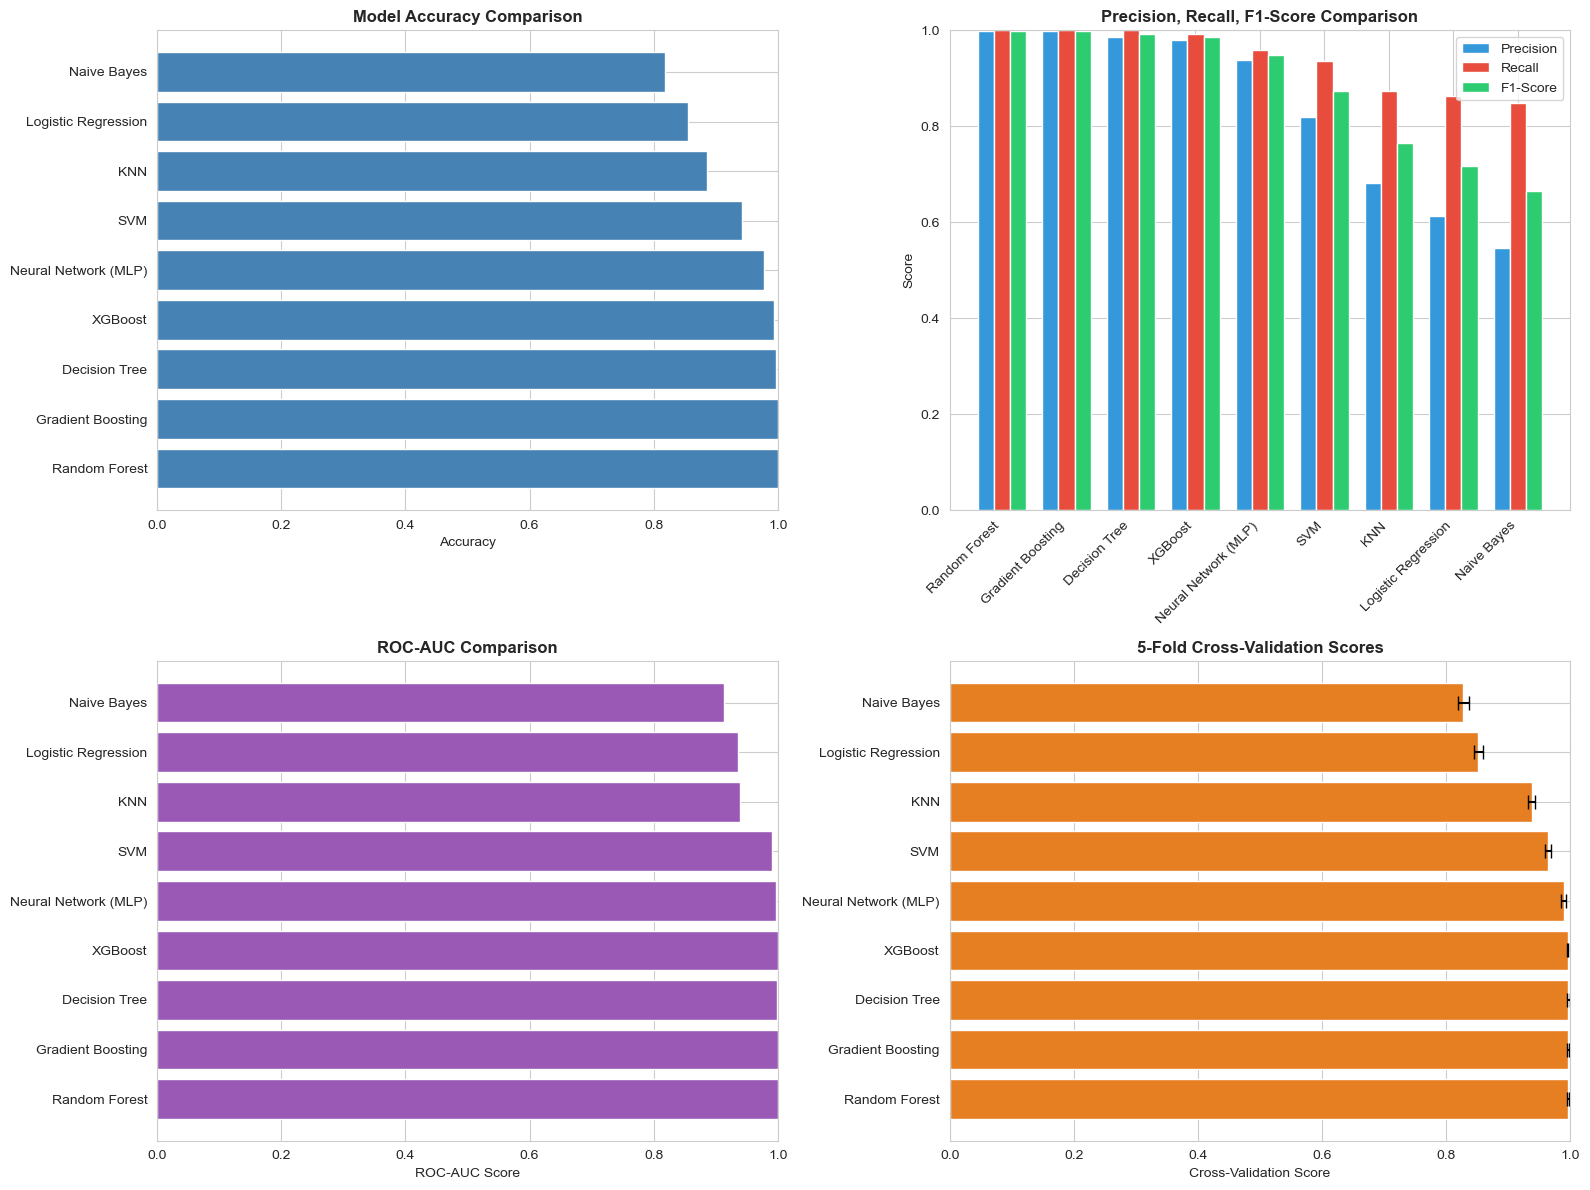

In [6]:
print("STEP 5: BINARY CLASSIFICATION RESULTS COMPARISON")

# Create comparison DataFrame
binary_comparison = pd.DataFrame({
    'Model': [r['Model'] for r in binary_results.values()],
    'Accuracy': [r['Accuracy'] for r in binary_results.values()],
    'Precision': [r['Precision'] for r in binary_results.values()],
    'Recall': [r['Recall'] for r in binary_results.values()],
    'F1-Score': [r['F1-Score'] for r in binary_results.values()],
    'ROC-AUC': [r['ROC-AUC'] for r in binary_results.values()],
    'CV_Mean': [r['CV_Mean'] for r in binary_results.values()],
    'CV_Std': [r['CV_Std'] for r in binary_results.values()]
})

binary_comparison = binary_comparison.sort_values('Accuracy', ascending=False)
print("\nBinary Classification Model Comparison:")
print(binary_comparison.to_string(index=False))

# Find best model
best_binary_model = binary_comparison.iloc[0]['Model']
print(f"\nBEST BINARY MODEL: {best_binary_model}")
print(f"   Accuracy: {binary_comparison.iloc[0]['Accuracy']:.4f}")
print(f"   ROC-AUC:  {binary_comparison.iloc[0]['ROC-AUC']:.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0, 0].barh(binary_comparison['Model'], binary_comparison['Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0, 0].set_xlim([0, 1])

# Precision, Recall, F1
x_pos = np.arange(len(binary_comparison))
width = 0.25
axes[0, 1].bar(x_pos - width, binary_comparison['Precision'], width, label='Precision', color='#3498db')
axes[0, 1].bar(x_pos, binary_comparison['Recall'], width, label='Recall', color='#e74c3c')
axes[0, 1].bar(x_pos + width, binary_comparison['F1-Score'], width, label='F1-Score', color='#2ecc71')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(binary_comparison['Model'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision, Recall, F1-Score Comparison', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])

# ROC-AUC comparison
axes[1, 0].barh(binary_comparison['Model'], binary_comparison['ROC-AUC'], color='#9b59b6')
axes[1, 0].set_xlabel('ROC-AUC Score')
axes[1, 0].set_title('ROC-AUC Comparison', fontweight='bold')
axes[1, 0].set_xlim([0, 1])

# Cross-validation scores with error bars
axes[1, 1].barh(binary_comparison['Model'], binary_comparison['CV_Mean'], 
                xerr=binary_comparison['CV_Std'], color='#e67e22', capsize=5)
axes[1, 1].set_xlabel('Cross-Validation Score')
axes[1, 1].set_title('5-Fold Cross-Validation Scores', fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

STEP 6: ROC CURVES ANALYSIS


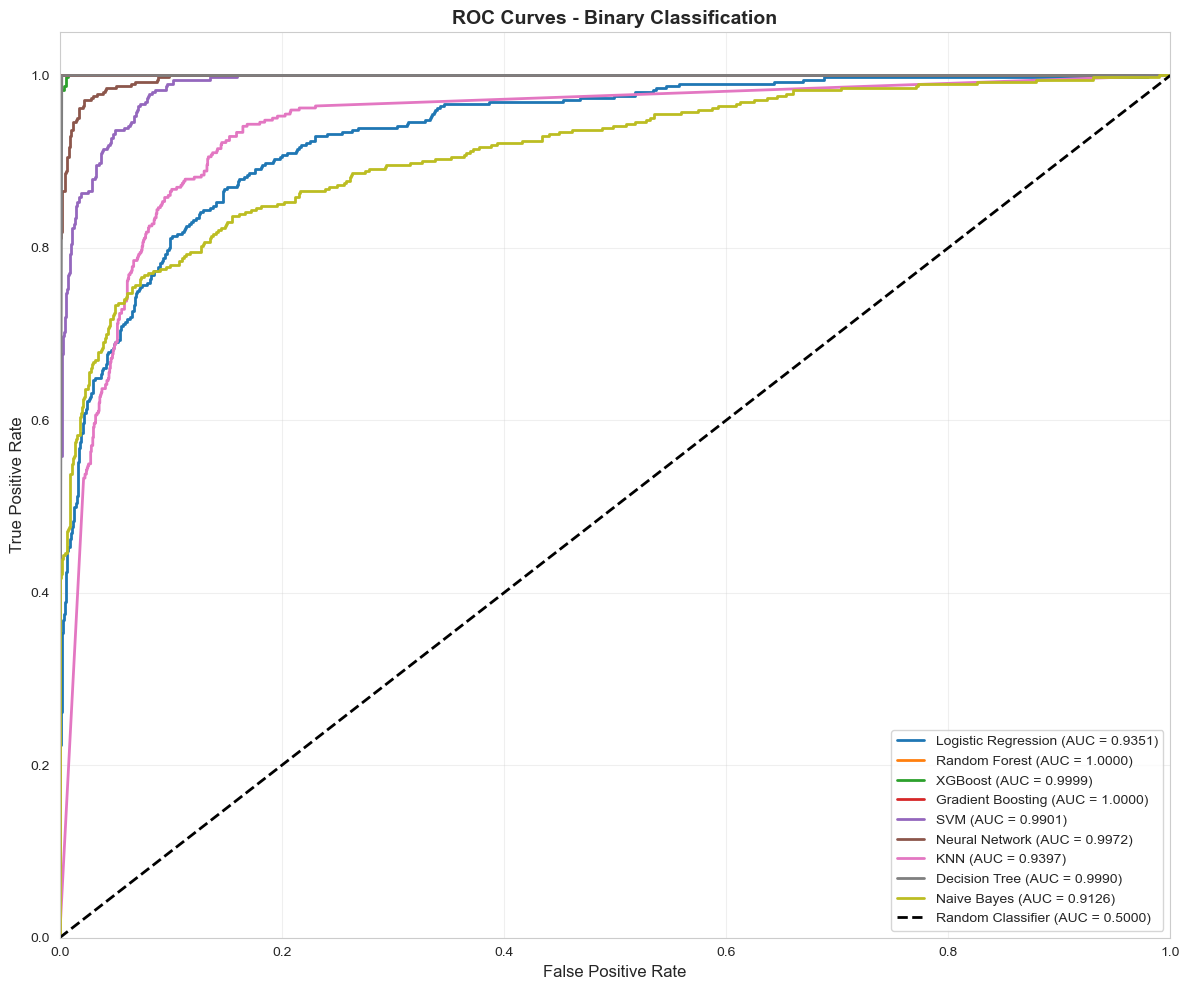

In [7]:
print("STEP 6: ROC CURVES ANALYSIS")

plt.figure(figsize=(12, 10))

for model_name, results in binary_results.items():
    if results['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test_bin, results['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Binary Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


STEP 7: CONFUSION MATRICES


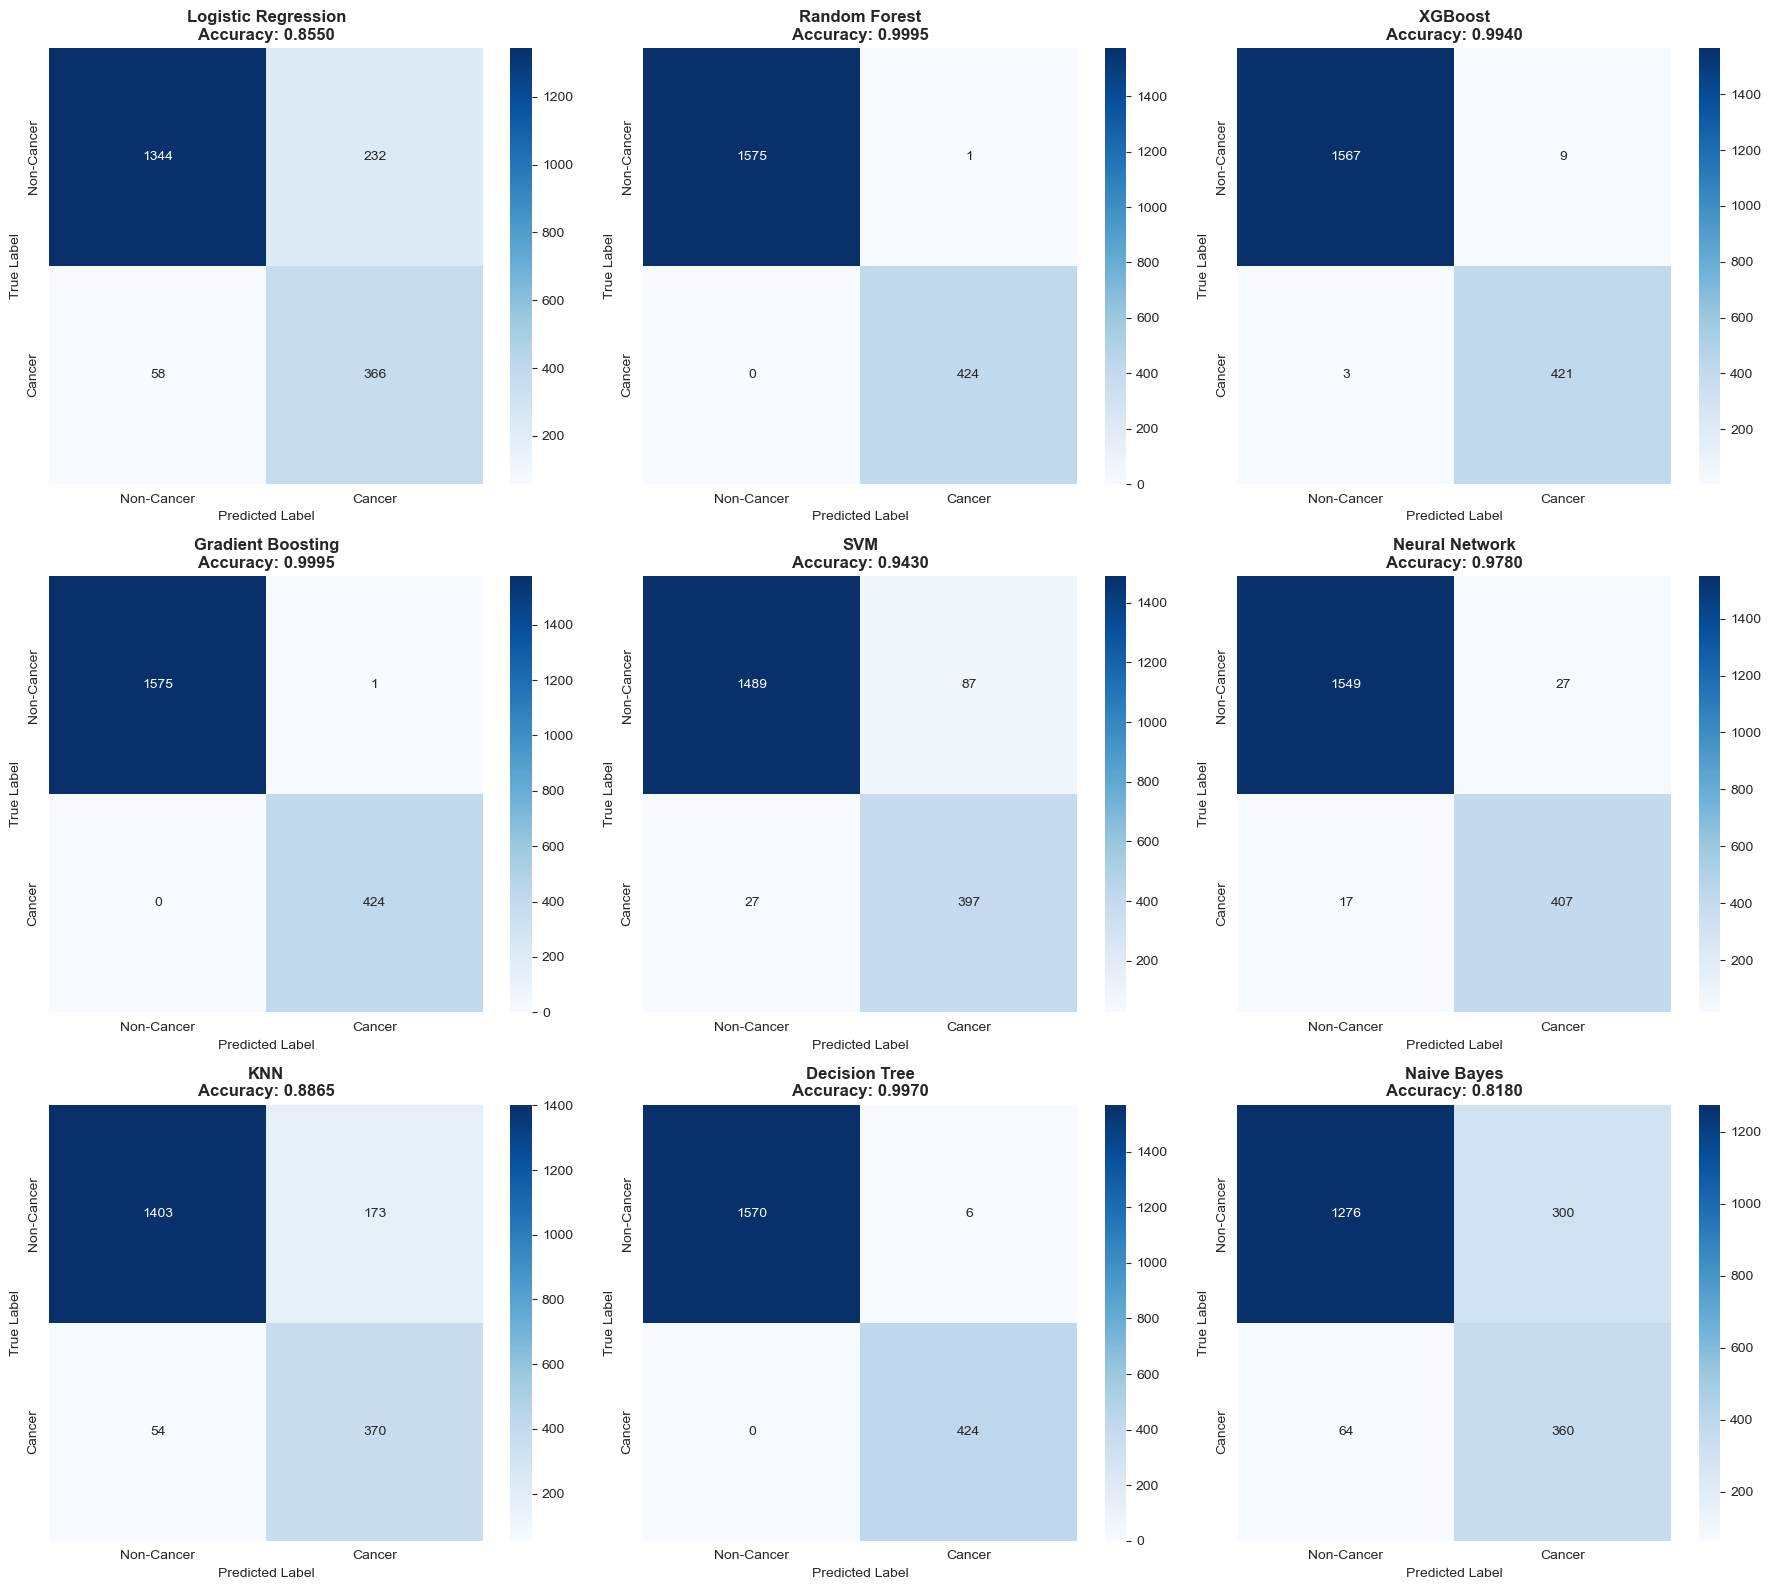

In [8]:
print("STEP 7: CONFUSION MATRICES")
print("="*80)

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.ravel()

for idx, (model_name, results) in enumerate(binary_results.items()):
    cm = results['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Cancer', 'Cancer'],
                yticklabels=['Non-Cancer', 'Cancer'])
    axes[idx].set_title(f'{model_name}\nAccuracy: {results["Accuracy"]:.4f}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


In [ ]:
print("STEP 8: MULTI-CLASS CLASSIFICATION (4 Diagnoses)")

# Dictionary to store results
multiclass_results = {}

# Function to evaluate multiclass model
def evaluate_multiclass_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a multi-class classification model"""
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # ROC-AUC for multiclass
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    else:
        roc_auc = None
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, 
                                                       target_names=le_multiclass.classes_)
    }
    
    return results

# 9.1 Logistic Regression (Multi-class)
print("\n" + "-"*80)
print("LOGISTIC REGRESSION (MULTI-CLASS)")
print("-"*80)

lr_multi_model = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    multi_class='multinomial'
)

lr_multi_results = evaluate_multiclass_model(
    lr_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'Logistic Regression'
)
multiclass_results['Logistic Regression'] = lr_multi_results

print(f"Accuracy:  {lr_multi_results['Accuracy']:.4f}")
print(f"Precision: {lr_multi_results['Precision']:.4f}")
print(f"Recall:    {lr_multi_results['Recall']:.4f}")
print(f"F1-Score:  {lr_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {lr_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {lr_multi_results['CV_Mean']:.4f} (+/- {lr_multi_results['CV_Std']:.4f})")

# Random Forest (Multi-class)
print("\n" + "-"*80)
print("RANDOM FOREST CLASSIFIER (MULTI-CLASS)")
print("-"*80)

rf_multi_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_multi_results = evaluate_multiclass_model(
    rf_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'Random Forest'
)
multiclass_results['Random Forest'] = rf_multi_results

print(f"Accuracy:  {rf_multi_results['Accuracy']:.4f}")
print(f"Precision: {rf_multi_results['Precision']:.4f}")
print(f"Recall:    {rf_multi_results['Recall']:.4f}")
print(f"F1-Score:  {rf_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {rf_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {rf_multi_results['CV_Mean']:.4f} (+/- {rf_multi_results['CV_Std']:.4f})")

# XGBoost (Multi-class)
print("\n" + "-"*80)
print("XGBOOST CLASSIFIER (MULTI-CLASS)")
print("-"*80)

xgb_multi_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    objective='multi:softprob'
)

xgb_multi_results = evaluate_multiclass_model(
    xgb_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'XGBoost'
)
multiclass_results['XGBoost'] = xgb_multi_results

print(f"Accuracy:  {xgb_multi_results['Accuracy']:.4f}")
print(f"Precision: {xgb_multi_results['Precision']:.4f}")
print(f"Recall:    {xgb_multi_results['Recall']:.4f}")
print(f"F1-Score:  {xgb_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {xgb_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {xgb_multi_results['CV_Mean']:.4f} (+/- {xgb_multi_results['CV_Std']:.4f})")

# Gradient Boosting (Multi-class)
print("\n" + "-"*80)
print("GRADIENT BOOSTING CLASSIFIER (MULTI-CLASS)")
print("-"*80)

gb_multi_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    random_state=42,
    subsample=0.8
)

gb_multi_results = evaluate_multiclass_model(
    gb_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'Gradient Boosting'
)
multiclass_results['Gradient Boosting'] = gb_multi_results

print(f"Accuracy:  {gb_multi_results['Accuracy']:.4f}")
print(f"Precision: {gb_multi_results['Precision']:.4f}")
print(f"Recall:    {gb_multi_results['Recall']:.4f}")
print(f"F1-Score:  {gb_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {gb_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {gb_multi_results['CV_Mean']:.4f} (+/- {gb_multi_results['CV_Std']:.4f})")

# SVM (Multi-class)
print("\n" + "-"*80)
print("SUPPORT VECTOR MACHINE (MULTI-CLASS)")
print("-"*80)

svm_multi_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42,
    decision_function_shape='ovr'
)

svm_multi_results = evaluate_multiclass_model(
    svm_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'SVM'
)
multiclass_results['SVM'] = svm_multi_results

print(f"Accuracy:  {svm_multi_results['Accuracy']:.4f}")
print(f"Precision: {svm_multi_results['Precision']:.4f}")
print(f"Recall:    {svm_multi_results['Recall']:.4f}")
print(f"F1-Score:  {svm_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {svm_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {svm_multi_results['CV_Mean']:.4f} (+/- {svm_multi_results['CV_Std']:.4f})")

# Neural Network (Multi-class)
print("\n" + "-"*80)
print("NEURAL NETWORK (MULTI-CLASS)")
print("-"*80)

mlp_multi_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_multi_results = evaluate_multiclass_model(
    mlp_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'Neural Network'
)
multiclass_results['Neural Network'] = mlp_multi_results

print(f"Accuracy:  {mlp_multi_results['Accuracy']:.4f}")
print(f"Precision: {mlp_multi_results['Precision']:.4f}")
print(f"Recall:    {mlp_multi_results['Recall']:.4f}")
print(f"F1-Score:  {mlp_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {mlp_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {mlp_multi_results['CV_Mean']:.4f} (+/- {mlp_multi_results['CV_Std']:.4f})")

# KNN (Multi-class)
print("\n" + "-"*80)
print("K-NEAREST NEIGHBORS (MULTI-CLASS)")
print("-"*80)

knn_multi_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='minkowski',
    n_jobs=-1
)

knn_multi_results = evaluate_multiclass_model(
    knn_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'KNN'
)
multiclass_results['KNN'] = knn_multi_results

print(f"Accuracy:  {knn_multi_results['Accuracy']:.4f}")
print(f"Precision: {knn_multi_results['Precision']:.4f}")
print(f"Recall:    {knn_multi_results['Recall']:.4f}")
print(f"F1-Score:  {knn_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {knn_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {knn_multi_results['CV_Mean']:.4f} (+/- {knn_multi_results['CV_Std']:.4f})")

# Decision Tree (Multi-class)
print("\n" + "-"*80)
print("DECISION TREE (MULTI-CLASS)")
print("-"*80)

dt_multi_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

dt_multi_results = evaluate_multiclass_model(
    dt_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'Decision Tree'
)
multiclass_results['Decision Tree'] = dt_multi_results

print(f"Accuracy:  {dt_multi_results['Accuracy']:.4f}")
print(f"Precision: {dt_multi_results['Precision']:.4f}")
print(f"Recall:    {dt_multi_results['Recall']:.4f}")
print(f"F1-Score:  {dt_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {dt_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {dt_multi_results['CV_Mean']:.4f} (+/- {dt_multi_results['CV_Std']:.4f})")

# Naive Bayes (Multi-class)
print("\n" + "-"*80)
print("NAIVE BAYES (MULTI-CLASS)")
print("-"*80)

nb_multi_model = GaussianNB()

nb_multi_results = evaluate_multiclass_model(
    nb_multi_model, X_train_balanced, X_test_scaled, 
    y_train_multi_balanced, y_test_multi, 'Naive Bayes'
)
multiclass_results['Naive Bayes'] = nb_multi_results

print(f"Accuracy:  {nb_multi_results['Accuracy']:.4f}")
print(f"Precision: {nb_multi_results['Precision']:.4f}")
print(f"Recall:    {nb_multi_results['Recall']:.4f}")
print(f"F1-Score:  {nb_multi_results['F1-Score']:.4f}")
print(f"ROC-AUC:   {nb_multi_results['ROC-AUC']:.4f}")
print(f"CV Score:  {nb_multi_results['CV_Mean']:.4f} (+/- {nb_multi_results['CV_Std']:.4f})")


STEP 8: MULTI-CLASS CLASSIFICATION (4 Diagnoses)

--------------------------------------------------------------------------------
LOGISTIC REGRESSION (MULTI-CLASS)
--------------------------------------------------------------------------------
Accuracy:  0.8255
Precision: 0.8777
Recall:    0.8255
F1-Score:  0.8361
ROC-AUC:   0.9560
CV Score:  0.8938 (+/- 0.0066)

--------------------------------------------------------------------------------
RANDOM FOREST CLASSIFIER (MULTI-CLASS)
--------------------------------------------------------------------------------
Accuracy:  0.9970
Precision: 0.9970
Recall:    0.9970
F1-Score:  0.9970
ROC-AUC:   1.0000
CV Score:  0.9988 (+/- 0.0005)

--------------------------------------------------------------------------------
XGBOOST CLASSIFIER (MULTI-CLASS)
--------------------------------------------------------------------------------
Accuracy:  0.9945
Precision: 0.9945
Recall:    0.9945
F1-Score:  0.9945
ROC-AUC:   1.0000
CV Score:  0.9984 (+/- 0

In [ ]:
print("STEP 9: MULTI-CLASS CLASSIFICATION RESULTS COMPARISON")

# Create comparison DataFrame
multiclass_comparison = pd.DataFrame({
    'Model': [r['Model'] for r in multiclass_results.values()],
    'Accuracy': [r['Accuracy'] for r in multiclass_results.values()],
    'Precision': [r['Precision'] for r in multiclass_results.values()],
    'Recall': [r['Recall'] for r in multiclass_results.values()],
    'F1-Score': [r['F1-Score'] for r in multiclass_results.values()],
    'ROC-AUC': [r['ROC-AUC'] for r in multiclass_results.values()],
    'CV_Mean': [r['CV_Mean'] for r in multiclass_results.values()],
    'CV_Std': [r['CV_Std'] for r in multiclass_results.values()]
})

multiclass_comparison = multiclass_comparison.sort_values('Accuracy', ascending=False)
print("\nMulti-class Classification Model Comparison:")
print(multiclass_comparison.to_string(index=False))

# Find best model
best_multiclass_model = multiclass_comparison.iloc[0]['Model']
print(f"\nBEST MULTI-CLASS MODEL: {best_multiclass_model}")
print(f"   Accuracy: {multiclass_comparison.iloc[0]['Accuracy']:.4f}")
print(f"   ROC-AUC:  {multiclass_comparison.iloc[0]['ROC-AUC']:.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0, 0].barh(multiclass_comparison['Model'], multiclass_comparison['Accuracy'], color='coral')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Multi-class Model Accuracy Comparison', fontweight='bold')
axes[0, 0].set_xlim([0, 1])

# Precision, Recall, F1
x_pos = np.arange(len(multiclass_comparison))
width = 0.25
axes[0, 1].bar(x_pos - width, multiclass_comparison['Precision'], width, label='Precision', color='#3498db')
axes[0, 1].bar(x_pos, multiclass_comparison['Recall'], width, label='Recall', color='#e74c3c')
axes[0, 1].bar(x_pos + width, multiclass_comparison['F1-Score'], width, label='F1-Score', color='#2ecc71')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(multiclass_comparison['Model'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision, Recall, F1-Score Comparison', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])

# ROC-AUC comparison
axes[1, 0].barh(multiclass_comparison['Model'], multiclass_comparison['ROC-AUC'], color='#16a085')
axes[1, 0].set_xlabel('ROC-AUC Score')
axes[1, 0].set_title('ROC-AUC Comparison', fontweight='bold')
axes[1, 0].set_xlim([0, 1])

# Cross-validation scores
axes[1, 1].barh(multiclass_comparison['Model'], multiclass_comparison['CV_Mean'], 
                xerr=multiclass_comparison['CV_Std'], color='#8e44ad', capsize=5)
axes[1, 1].set_xlabel('Cross-Validation Score')
axes[1, 1].set_title('5-Fold Cross-Validation Scores', fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [ ]:
print("STEP 10: MULTI-CLASS CONFUSION MATRICES")

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.ravel()

for idx, (model_name, results) in enumerate(multiclass_results.items()):
    cm = results['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=axes[idx],
                xticklabels=le_multiclass.classes_,
                yticklabels=le_multiclass.classes_)
    axes[idx].set_title(f'{model_name}\nAccuracy: {results["Accuracy"]:.4f}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()